In [156]:
import wfdb
import mne
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

record_path = "Desktop/PSG data/Raw Data/slp01a"

record = wfdb.rdrecord(record_path)
annotation = wfdb.rdann(record_path, 'st')

annotation_mne = mne.Annotations(
    onset=annotation.sample / record.fs,
    duration=30,
    description=annotation.aux_note
)

signals = record.p_signal  # Signal data as NumPy array
sampling_rate = record.fs  # Sampling frequency (e.g., 250 Hz)
channel_names = record.sig_name  # Channel names

seen_categories = set()

# Assign types while ensuring only the first occurrence is assigned correctly
channel_types = []
channel_names_updated = []

for ch in channel_names:
    if "EEG" in ch and "EEG" not in seen_categories:
        channel_types.append("eeg")
        channel_names_updated.append("EEG")
        seen_categories.add("EEG")
    elif "Resp" in ch and "Resp" not in seen_categories:
        channel_types.append("resp")
        channel_names_updated.append("Respiratory")
        seen_categories.add("Resp")
    elif "ECG" in ch and "ECG" not in seen_categories:
        channel_types.append("ecg")
        channel_names_updated.append("ECG")
        seen_categories.add("ECG")
    else:
        channel_types.append("misc")
        channel_names_updated.append("misc")
# Create MNE Info object
info = mne.create_info(
    ch_names=channel_names_updated,
    sfreq=sampling_rate,
    ch_types=channel_types
)

# Convert signals to MNE RawArray
raw = mne.io.RawArray(signals.T, info)

# Add annotations to the raw object
raw.set_annotations(annotation_mne)
#Set chhannel types to correct
raw.info

Creating RawArray with float64 data, n_channels=4, n_times=1800000
    Range : 0 ... 1799999 =      0.000 ...  7199.996 secs
Ready.


<Info | 7 non-empty values
 bads: []
 ch_names: ECG, misc, EEG, Respiratory
 chs: 1 ECG, 1 misc, 1 EEG, 1 Respiration monitoring channel
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 4
 projs: []
 sfreq: 250.0 Hz
>

In [158]:
raw

<RawArray | 4 x 1800000 (7200.0 s), ~54.9 MiB, data loaded>

In [2]:
# Reclassify events
new_id = {}
for desc in raw.annotations.description:
    if "H" in desc or "HA" in desc:  # Hypopnea
        new_id[desc] = 1
    elif " A " in desc or "X" in desc:  # Obstructive Apnea
        new_id[desc] = 2
    elif "CA" in desc or "CAA" in desc:  # Central Apnea
        new_id[desc] = 3
    else:  # Other
        new_id[desc] = 4

# Generate events with the new mapping
events, event_id = mne.events_from_annotations(raw, event_id=new_id)

new_annotations = mne.Annotations(
    onset=events[:, 0] / raw.info["sfreq"],  # Convert sample index to seconds
    duration=[30] * len(events),  # Assume each event lasts 30 seconds
    description=[e for e in events[:, 2]]  # Convert IDs back to labels
)

# Set the new annotations in raw
raw.set_annotations(None)
raw.set_annotations(new_annotations)
raw_copy=raw.copy()
raw_train,raw_test=raw.crop(tmin=0,tmax=5999),raw_copy.crop(tmin=6000,tmax=7000)
events_train, event_id_train = mne.events_from_annotations(raw_train,event_id={"1":1,"2":2,"3":3,"4":4})
events_test, event_id_test = mne.events_from_annotations(raw_test,event_id={"1":1,"2":2,"3":3,"4":4})

Used Annotations descriptions: ['1 LA', '2', '2 H', '2 H H', '2 H LA', '2 HA', '2 L', '2 L HA', '2 L LA', '2 LA', '2 LA H', '2 LA HA', '2 LA L', '2 LA LA', '3', '3 H', '3 H LA', '3 HA', '3 L', '3 L HA LA', '3 L L', '3 L LA', '3 LA', '3 LA L', '3 LA LA', '4', '4 L', '4 L L', '4 L L L', '4 L LA', '4 LA', '4 LA HA LA', '4 LA L', '4 LA LA', 'MT', 'R', 'R H', 'R HA', 'W', 'W HA', 'W LA']
Used Annotations descriptions: ['1', '4']
Used Annotations descriptions: ['1', '4']


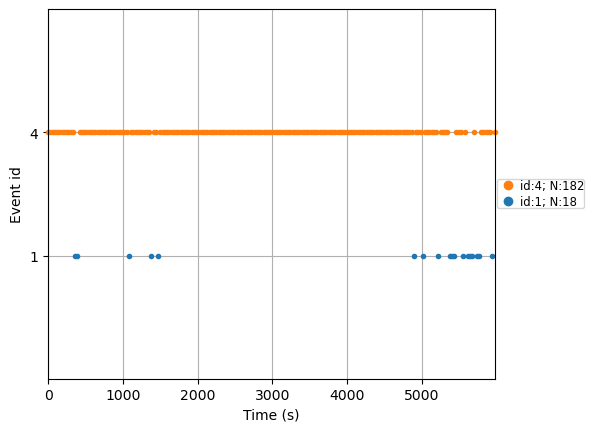

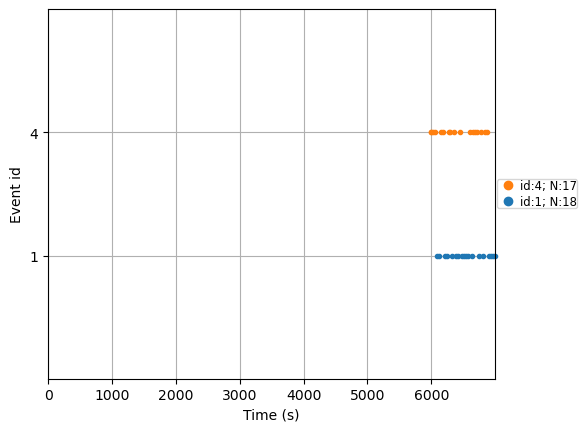

In [160]:
import matplotlib.pyplot as plt
# Plot the events
fig = mne.viz.plot_events(
    events_train,
    sfreq=raw.info["sfreq"],  # Sampling frequency of the raw data
    first_samp=raw.first_samp,  # First sample index of the raw data
)

# Extract color cycle for event colors
stage_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

plt.show()
import matplotlib.pyplot as plt
# Plot the events
fig = mne.viz.plot_events(
    events_test,
    sfreq=raw.info["sfreq"],  # Sampling frequency of the raw data
    first_samp=raw.first_samp,  # First sample index of the raw data
)

# Extract color cycle for event colors
stage_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

plt.show()

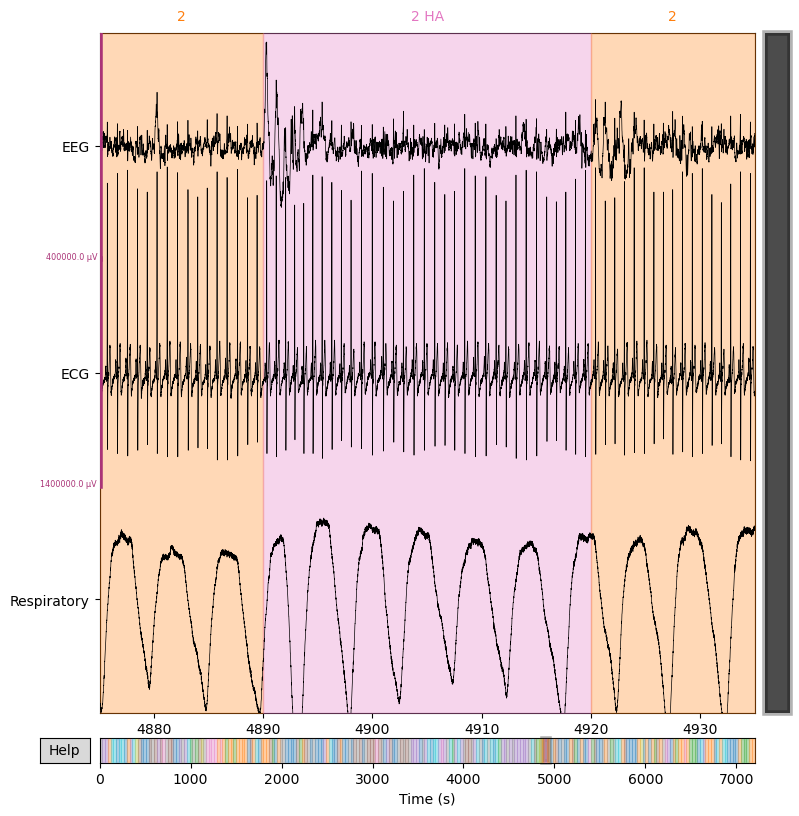

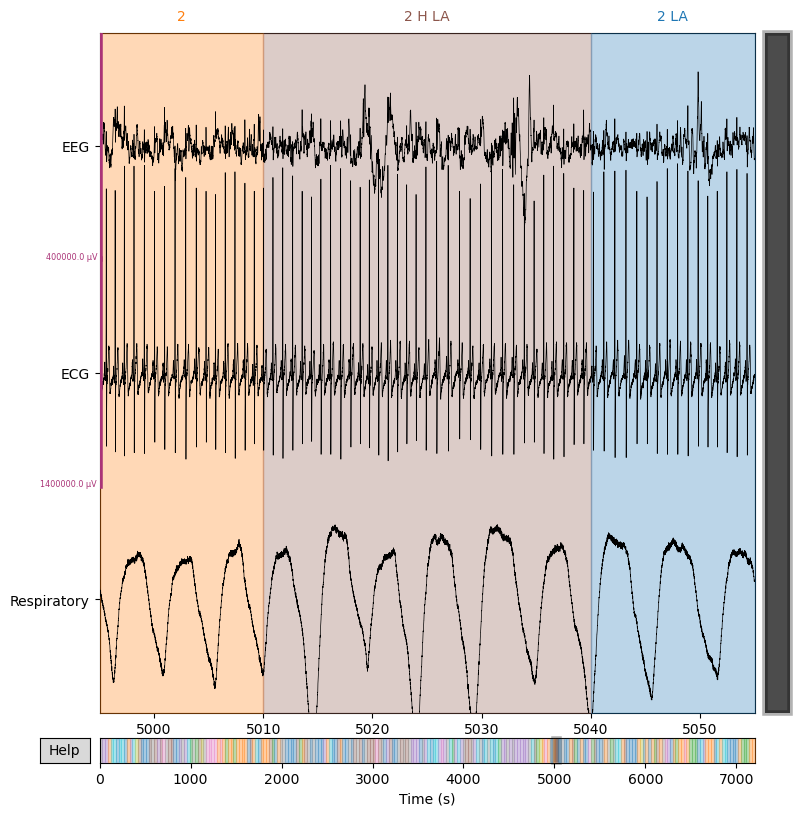

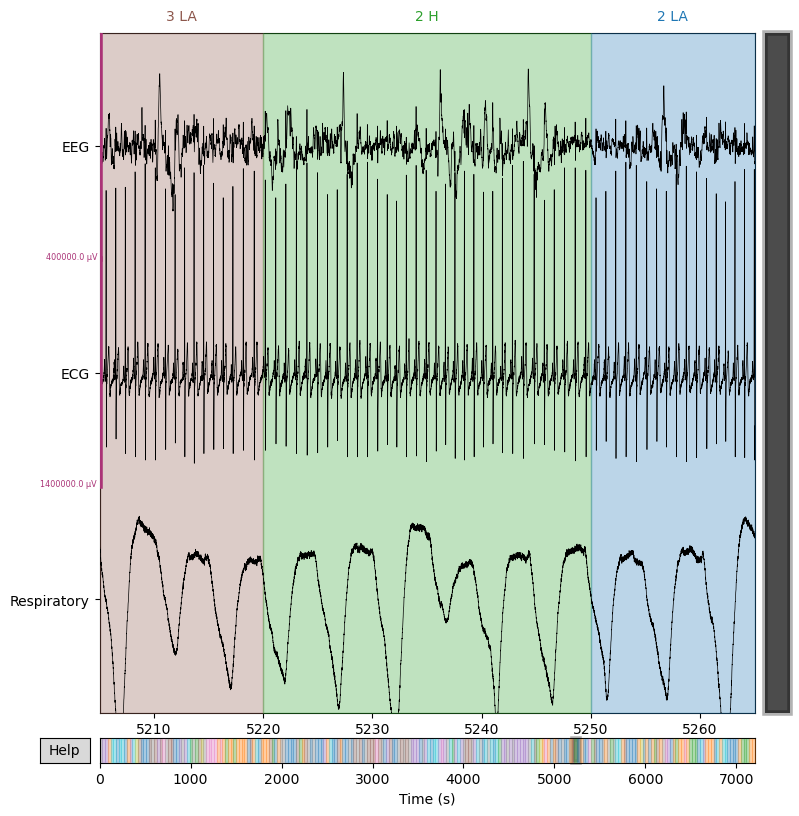

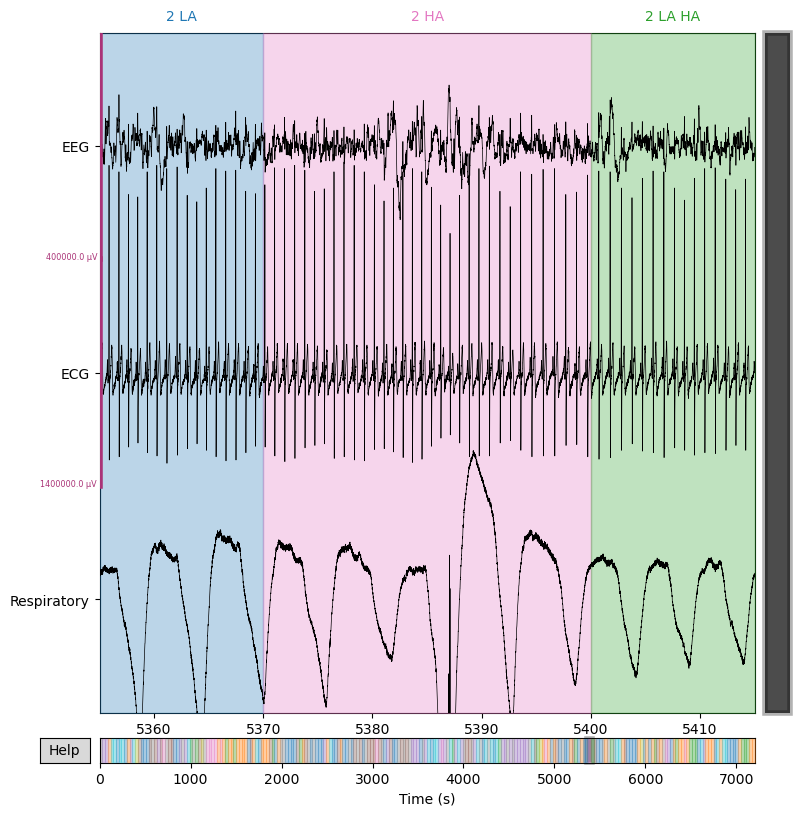

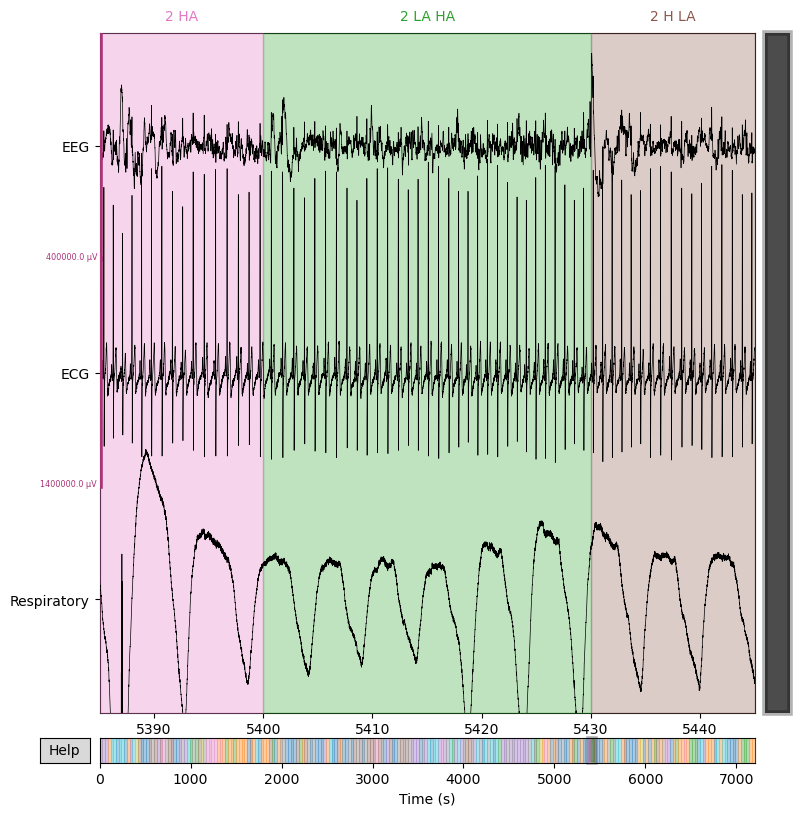

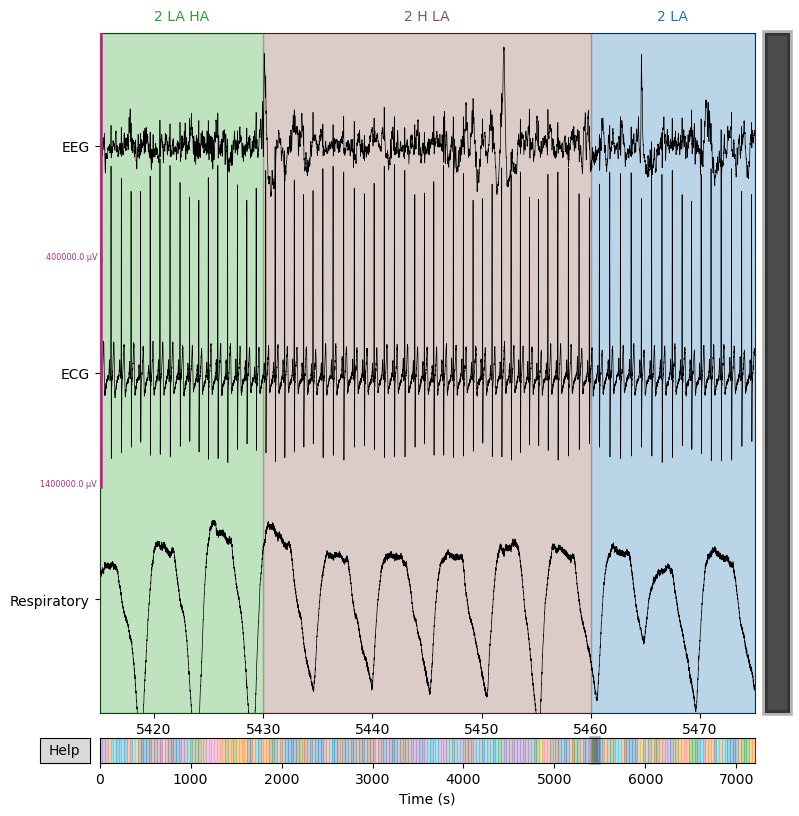

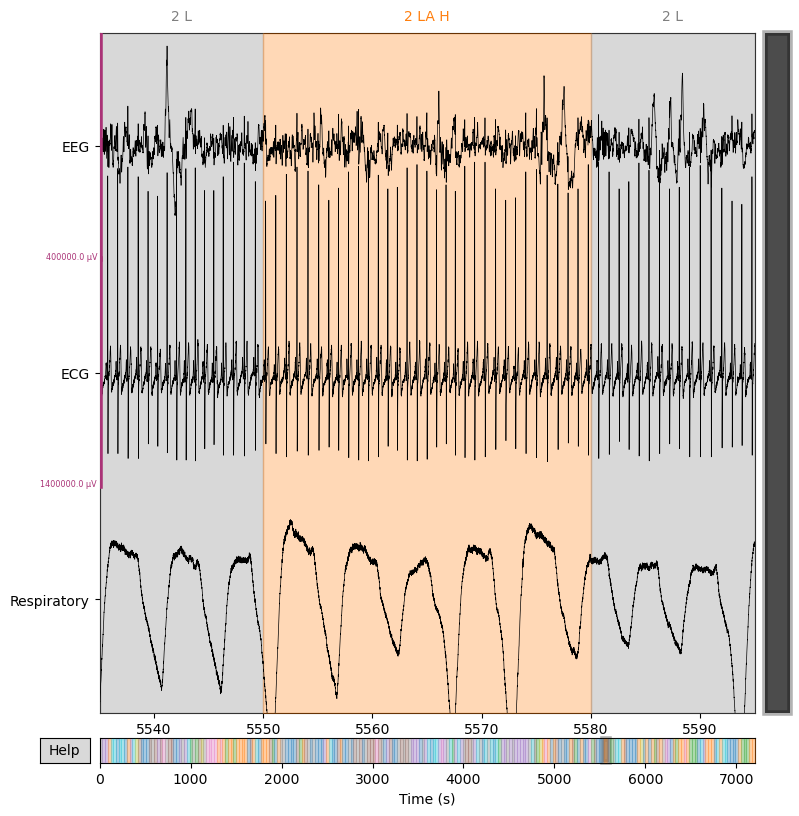

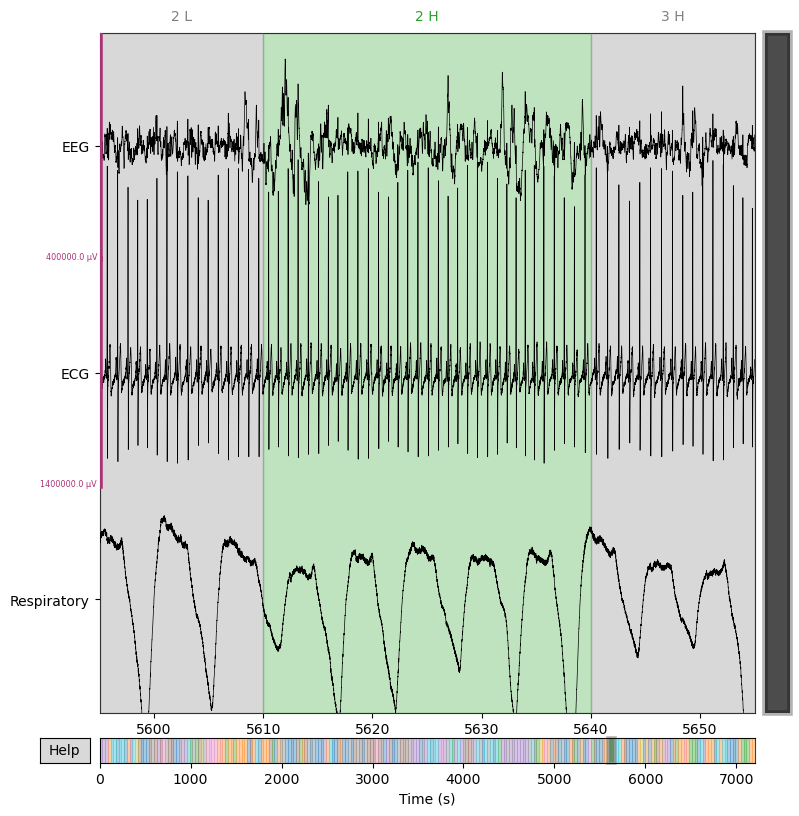

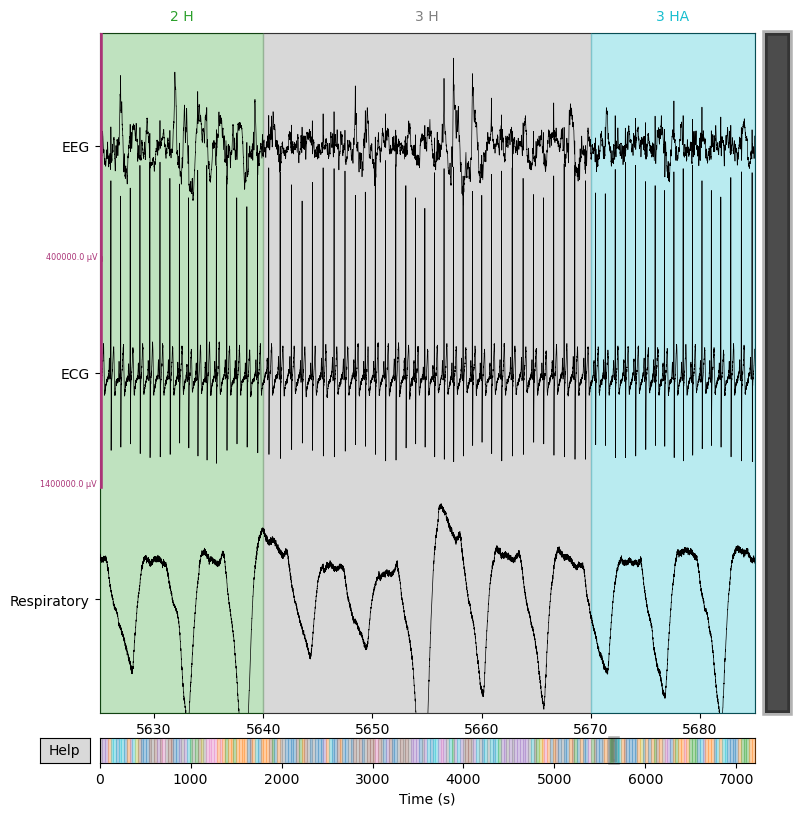

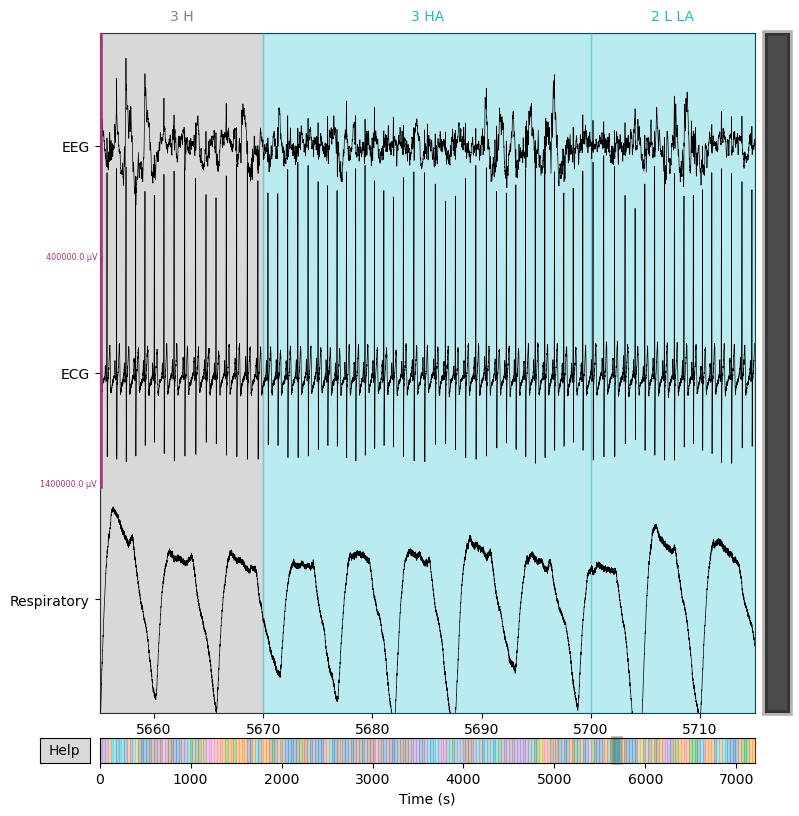

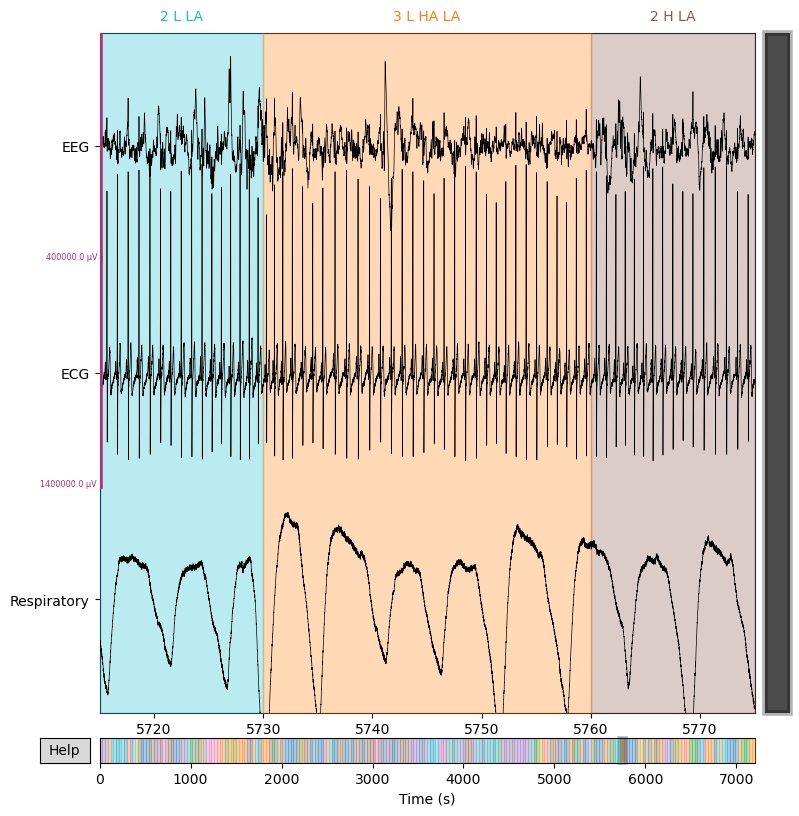

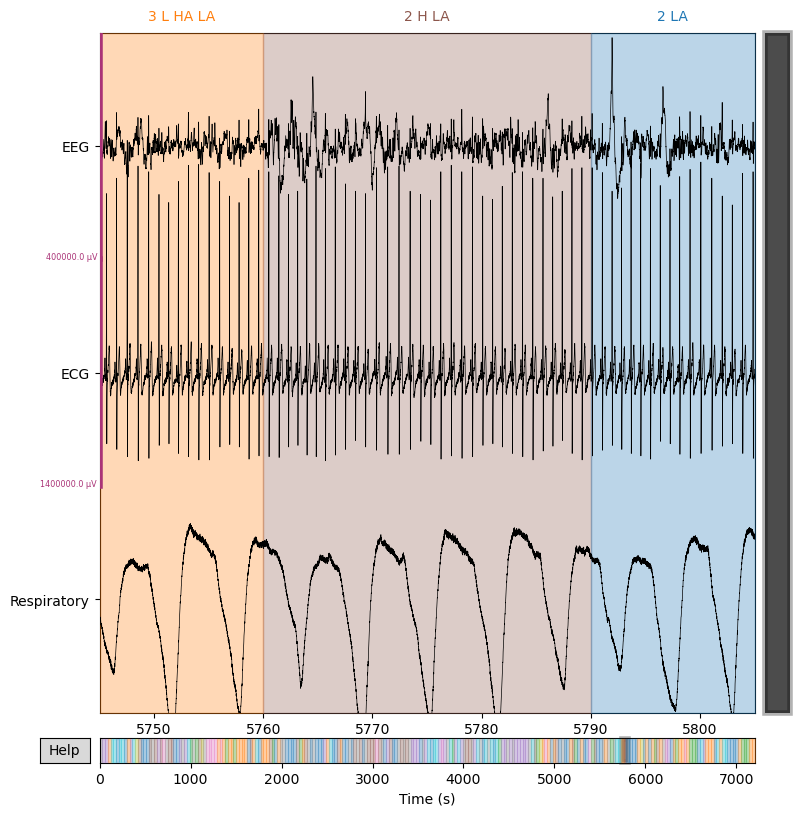

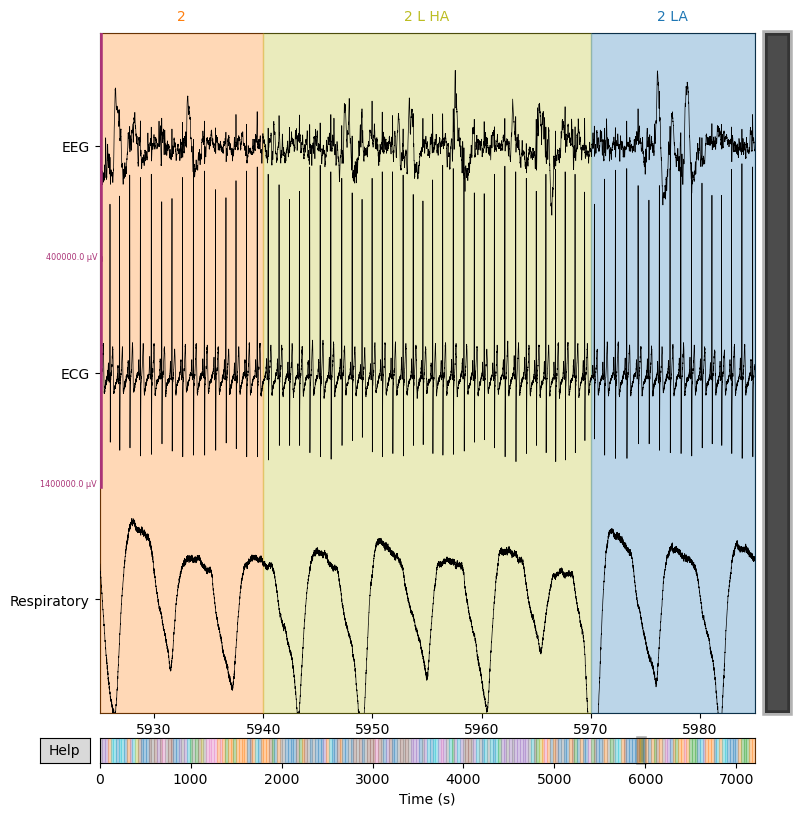

In [164]:
# making sure annotations correspond to "something".
for i in events_train[-100:]:
    if i[-1]!=4:
        raw.plot(start=i[0]/250-15,duration=60,color="k",
            picks=["ECG",'Respiratory',"EEG"],
            scalings=dict(eeg=0.2,  ecg=0.7, resp=1,misc=50),
            title="PSG Data Excluding BP")

In [40]:
tmax = 30.0 - 1.0 / raw.info["sfreq"]  # tmax in included
epochs_train = mne.Epochs(
    raw_train,
    events=events_train,
    tmin=0.0,
    tmax=tmax,
    baseline=None,
    picks=["ECG","BP",'Respiratory',"EEG (C4-A1)"]
)
epochs_test=mne.Epochs(
    raw_test,
    events=events_test,
    tmin=0.0,
    tmax=tmax,
    baseline=None,
    event_repeated="merge",
    picks=["ECG","BP",'Respiratory',"EEG (C4-A1)"]
)

Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
34 matching events found
No baseline correction applied
0 projection items activated


Using data from preloaded Raw for 18 events and 7500 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
Using data from preloaded Raw for 181 events and 7500 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


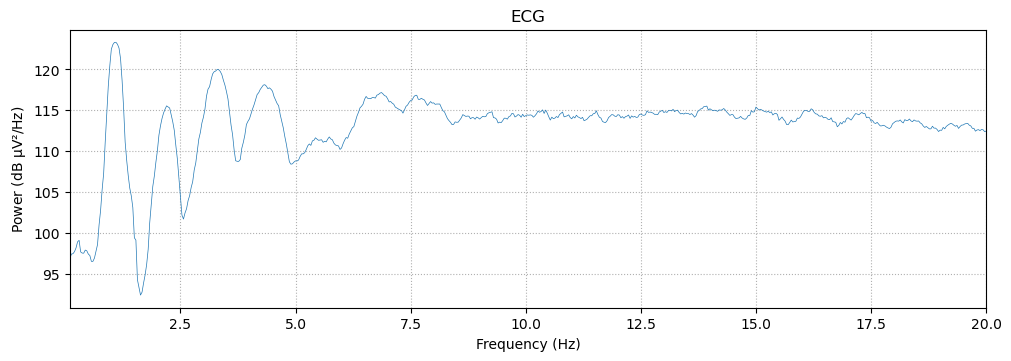

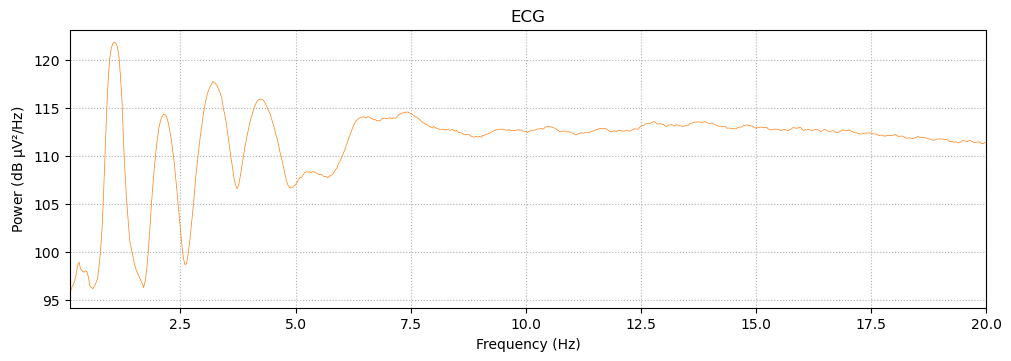

Using data from preloaded Raw for 17 events and 7500 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
Using data from preloaded Raw for 16 events and 7500 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


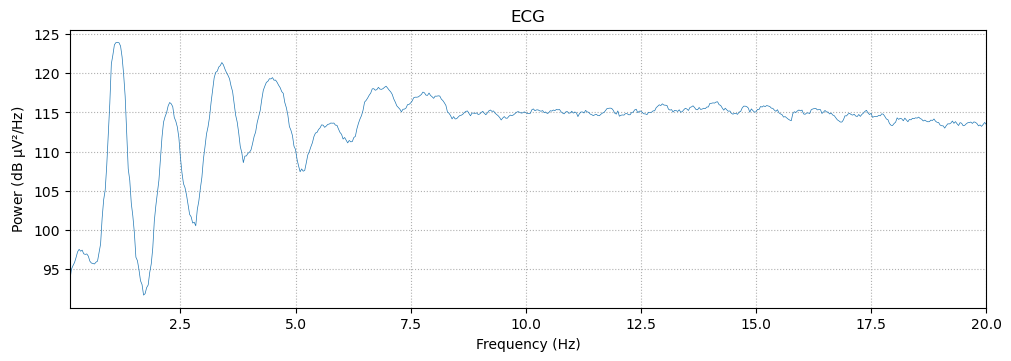

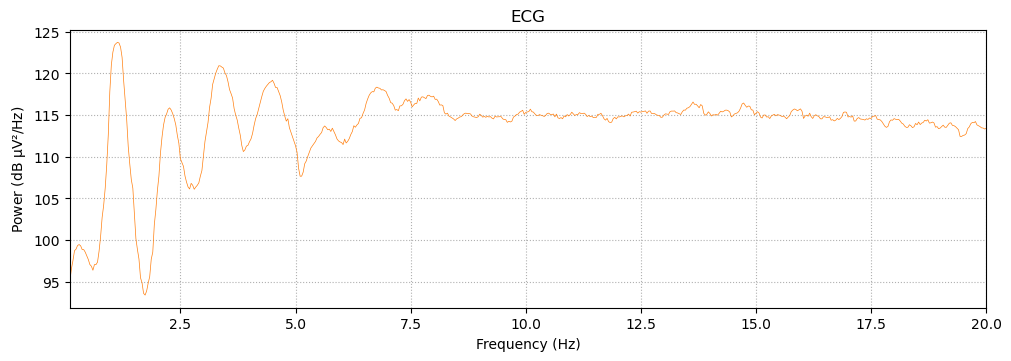

In [54]:
for eve,color in zip(["1","4"],stage_colors):
    spectrum=epochs_train[eve].compute_psd(fmin=0.1,fmax=20.0,picks="ECG")
    spectrum.plot(ci=None,
            color=color,
            show=False,
            average=True,
            amplitude=False,
            spatial_colors=False,
            picks="ECG"
        )
plt.show()
for eve,color in zip(["1","4"],stage_colors):
    spectrum=epochs_test[eve].compute_psd(fmin=0.1,fmax=20.0,picks="ECG")
    spectrum.plot(ci=None,
            color=color,
            show=False,
            average=True,
            amplitude=False,
            spatial_colors=False,
            picks="ECG"
        )
plt.show()

In [112]:
def power_band(epochs):
    # specific frequency bands
    FREQ_BANDS = {
        "delta": [0.5, 4.5],
        "theta": [4.5, 8.5],
        "alpha": [8.5, 11.5],
        "sigma": [11.5, 15.5],
        "beta": [15.5, 30],
    }

    spectrum = epochs.compute_psd( fmin=0.5, fmax=30.0,picks="ECG")
    psds, freqs = spectrum.get_data(return_freqs=True,picks="ECG")
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

In [114]:
pipe = make_pipeline(
    FunctionTransformer(power_band, validate=False),
    RandomForestClassifier(n_estimators=1100, random_state=41),
)

# Train
y_train = epochs_train.events[:, 2]
pipe.fit(epochs_train, y_train)

# Test
y_pred = pipe.predict(epochs_test)

# Assess the results
y_test = epochs_test.events[:, 2]
acc = accuracy_score(y_test, y_pred)

print(f"Accuracy score: {acc}")

Using data from preloaded Raw for 199 events and 7500 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Using data from preloaded Raw for 33 events and 7500 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Accuracy score: 0.5151515151515151


In [102]:
epochs_train.info

<Info | 7 non-empty values
 bads: []
 ch_names: ECG, BP, Resp (sum), EEG (C4-A1)
 chs: 1 ECG, 1 misc, 1 Respiration monitoring channel, 1 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 4
 projs: []
 sfreq: 250.0 Hz
>

Using data from preloaded Raw for 18 events and 7500 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
Using data from preloaded Raw for 182 events and 7500 original time points ...
1 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
Using data from preloaded Raw for 18 events and 7500 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
Using data from preloaded Raw for 182 events and 7500 original time points ...
1 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


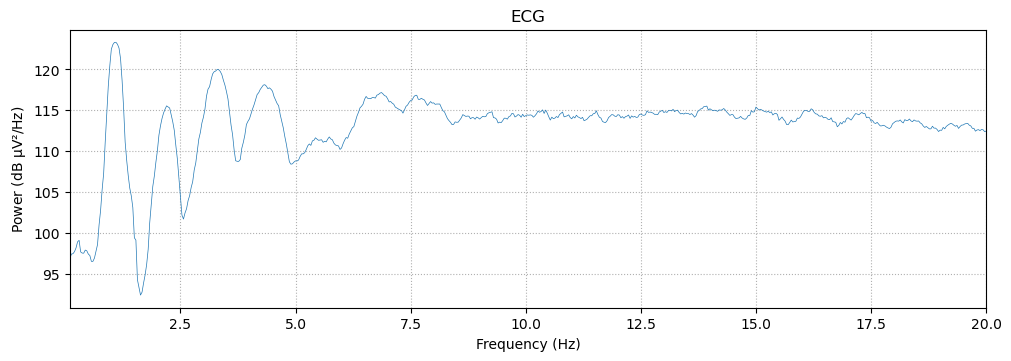

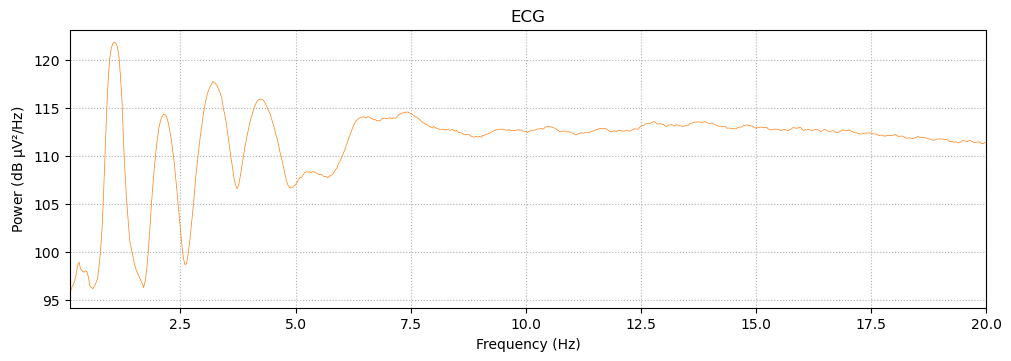

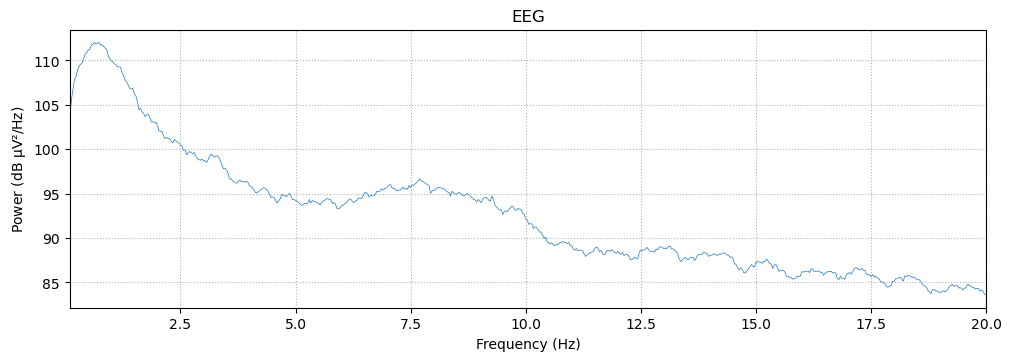

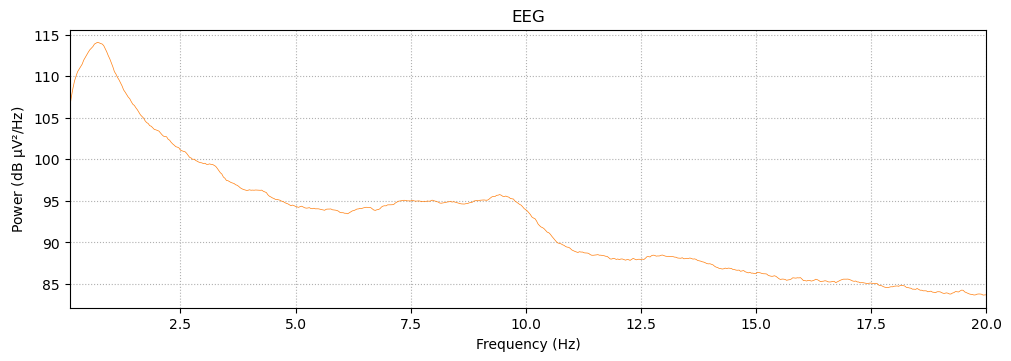

In [32]:
for eve,color in zip(["1","4"],stage_colors):
    spectrum=epochs_train[eve].compute_psd(fmin=0.1,fmax=20.0,picks="ECG")
    spectrum.plot(ci=None,
            color=color,
            show=False,
            average=True,
            amplitude=False,
            spatial_colors=False,
            picks="ECG"
        )
for eve,color in zip(["1","4"],stage_colors):
    spectrum=epochs_train[eve].compute_psd(fmin=0.1,fmax=20.0,picks="all")
    spectrum.plot(ci=None,
            color=color,
            show=False,
            average=True,
            amplitude=False,
            spatial_colors=False,
        )

In [ ]:
print("Available channels:", epochs_train["1"].get_channel_types)
print("Available channels:", epochs_train["1"].ch_names.index("BP"))

In [ ]:
epochs_train.info